In [1]:
!ls -la PokemonData/ | head

total 172
drwxr-xr-x 43 vdimitrov users 4096 Nov 16 23:22 .
drwxr-x--- 18 vdimitrov users 4096 Nov 16 22:26 ..
drwxr-xr-x  2 vdimitrov users 4096 Nov 16 22:59 Abra
drwxr-xr-x  2 vdimitrov users 4096 Nov 16 22:59 Alakazam
drwxr-xr-x  2 vdimitrov users 4096 Nov 16 22:59 Alolan Sandslash
drwxr-xr-x  2 vdimitrov users 4096 Nov 16 23:23 Arcanine
drwxr-xr-x  2 vdimitrov users 4096 Nov 16 23:23 Articuno
drwxr-xr-x  2 vdimitrov users 4096 Nov 16 22:59 Bellsprout
drwxr-xr-x  2 vdimitrov users 4096 Nov 16 23:23 Charmeleon


In [15]:
!du -sh PokemonData/ | head

113M	PokemonData/


In [3]:
!nvidia-smi

Thu Nov 16 23:23:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:03:00.0 Off |                    0 |
| N/A   41C    P0    38W / 250W |   1746MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  On   | 00000000:03:01.0 Off |                    0 |
| N/A   

In [4]:
import glob
import os
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import random 
from scripts.train_model import train
from scripts.plot_loss import plot_losses
import warnings 

warnings.filterwarnings("ignore")

In [63]:
def delete():
    bad_images = glob.glob('PokemonData/*/*.svg')
    for bad_image in bad_images:
        os.remove(bad_image)
    bad_files = glob.glob('PokemonData/*/.ipynb_checkpoints')
    for bad_file in bad_files:
        os.rmdir(bad_file)

In [52]:
import os
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm


class PokemonDataset(Dataset):
    SPLIT_RANDOM_SEED = 42
    TEST_SIZE = 0.25

    def __init__(self, root, train=True, load_to_ram=True, transform=None):
        super().__init__()
        self.root = root
        self.train = train
        self.load_to_ram = load_to_ram
        self.transform = transform
        self.to_tensor = T.ToTensor()
        self.all_files = []
        self.all_labels = []
        self.images = []

        self.classes = sorted(os.listdir(self.root))
        for i, class_name in tqdm(enumerate(self.classes), total=len(self.classes)):
            files = sorted(os.listdir(os.path.join(self.root, class_name)))
            train_files, test_files = train_test_split(files, random_state=self.SPLIT_RANDOM_SEED + i,
                                                       test_size=self.TEST_SIZE)
            if self.train:
                self.all_files += train_files
                self.all_labels += [i] * len(train_files)
                if self.load_to_ram:
                    self.images += self._load_images(train_files, i)

            else:
                self.all_files += test_files
                self.all_labels += [i] * len(test_files)
                if self.load_to_ram:
                    self.images += self._load_images(test_files, i)

    def _load_images(self, image_files, label):
        images = []
        for filename in image_files:
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')
            images += [image]

        return images

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, item):
        label = self.all_labels[item]
        if self.load_to_ram:
            image = self.images[item]
        else:
            filename = self.all_files[item]
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [18]:
train_dataset = PokemonDataset(root='PokemonData', train=True, load_to_ram=False)

Loading files:   0%|          | 0/41 [00:00<?, ?it/s]

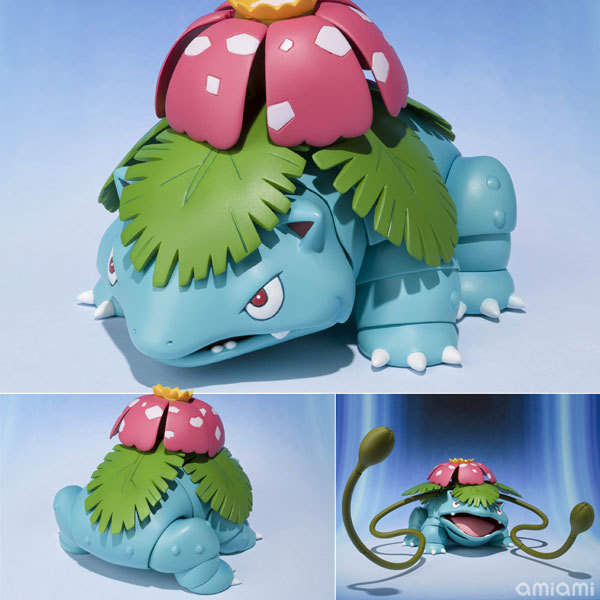

In [19]:
random_images = random.randint(0, len(train_dataset))
image, label = train_dataset[random_images]
image

In [20]:
train_dataset.classes[label]

'Venusaur'

In [21]:
len(train_dataset)

1450

In [53]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.5, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize,
])

test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    normalize,
])

In [64]:
delete()
train_dataset = PokemonDataset(root='PokemonData', train=True, load_to_ram=False, 
                               transform=train_transform)
test_dataset = PokemonDataset(root='PokemonData', train=False, load_to_ram=False,
                              transform=test_transform)

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

In [70]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=2) # pin_memorry - ускоряет обучение 

In [73]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

NUM_EPOCHS = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = mobilenet_v2(pretrained=False, num_classes=len(train_dataset.classes)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)
criterion = torch.nn.CrossEntropyLoss()

In [72]:
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [74]:
print(f'Parameters: {sum(param.numel() for param in model.parameters() if param.requires_grad) / 1_000_000: .2f} M')

Parameters:  2.28 M


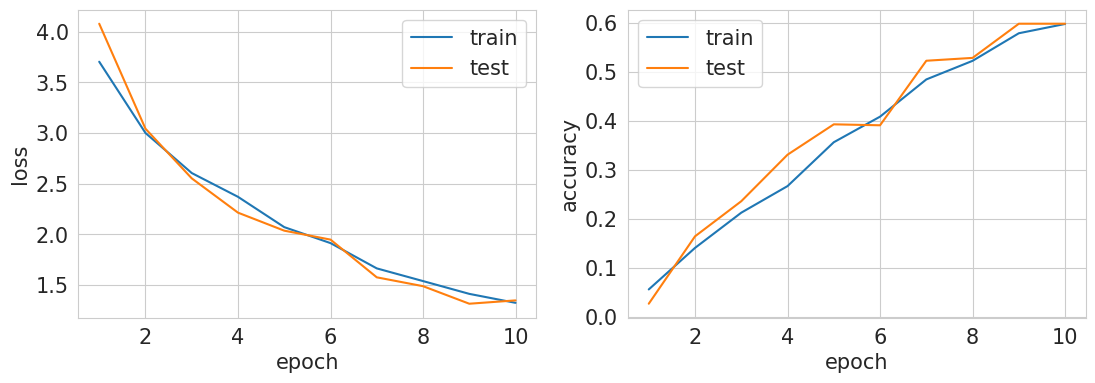

In [75]:
train(model=model, train_loader=train_loader, test_loader=test_loader, scheduler=scheduler, NUM_EPOCHS=NUM_EPOCHS,
      optimizer=optimizer,criterion=criterion, device=device)

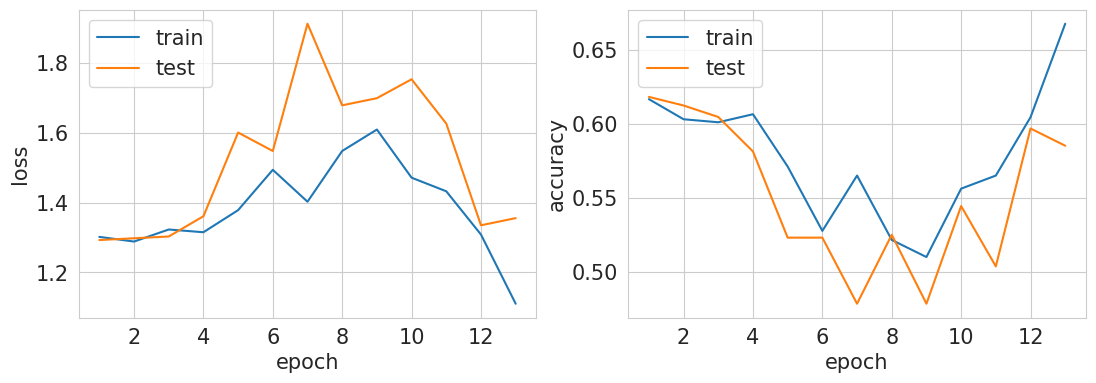

Training:  21%|███████                          | 10/47 [00:01<00:04,  8.41it/s]


KeyboardInterrupt: 

In [76]:
NUM_EPOCHS=20
train(model=model, train_loader=train_loader, test_loader=test_loader, scheduler=scheduler, NUM_EPOCHS=NUM_EPOCHS,
      optimizer=optimizer,criterion=criterion, device=device)

### Add augmentation

In [77]:
train_dataset.transform = train_transform
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)

In [80]:
NUM_EPOCHS = 20
model = mobilenet_v2(num_classes=len(train_dataset.classes)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)

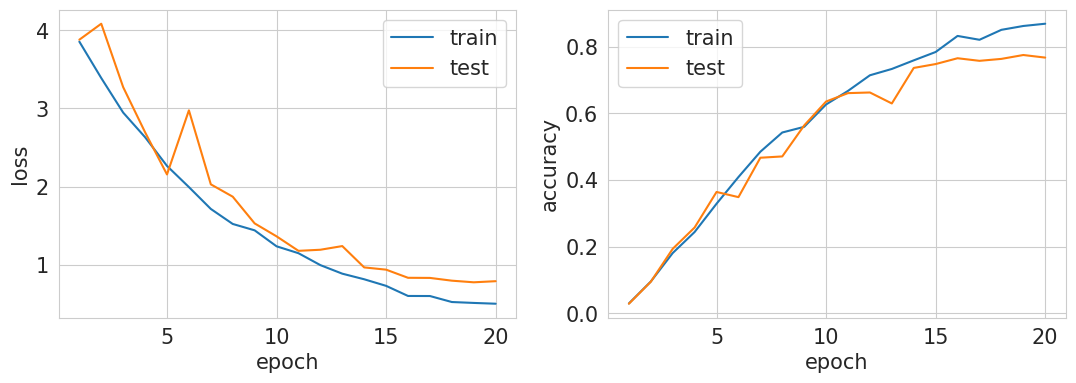

In [81]:
train(model=model, train_loader=train_loader, test_loader=test_loader, scheduler=scheduler, NUM_EPOCHS=NUM_EPOCHS,
      optimizer=optimizer,criterion=criterion, device=device)

### Fine-tuning model

In [82]:
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
# Заменяем исходную голову модели на голову с правильным числом классов
model.classifier[1] = torch.nn.Linear(1280, len(train_dataset.classes))
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/vdimitrov/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████████████████████████████████| 13.6M/13.6M [00:00<00:00, 35.0MB/s]


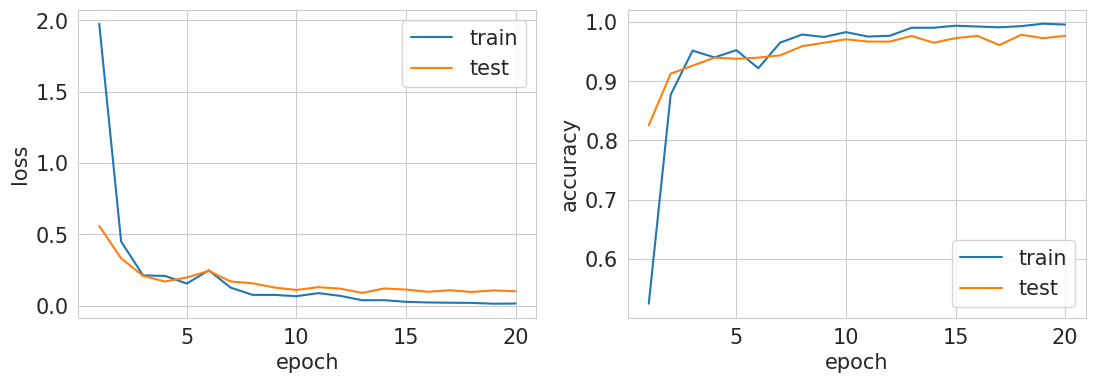

In [83]:
train(model=model, train_loader=train_loader, test_loader=test_loader, scheduler=scheduler, NUM_EPOCHS=NUM_EPOCHS,
      optimizer=optimizer,criterion=criterion, device=device)

In [87]:
!rm -r PokemonData/
torch.cuda.empty_cache() 